Performance de estudantes

# Importação do que é necessário para execução do código em Python.

In [31]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Classificadores
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Carga do Dataset

In [32]:
# Informa a URL de importação do dataset
base_url = 'https://raw.githubusercontent.com'
author = 'jonathangsilveira'
repo = 'mvp-predicao-media-alunos-api'
dataset_filepath = 'main/machine_learning/data/performance-alunos-dataset.csv'
url = f'{base_url}/{author}/{repo}/{dataset_filepath}'

# Lê o arquivo
dataset = pd.read_csv(url, skiprows=0, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Remover colunas desnecessárias do *Dataframe*

In [33]:
dataset.drop(['StudentID', 'GPA'], axis=1, inplace=True)

dataset.shape

(2392, 13)



*   A coluna alvo é `GradeClass`, isso porquê a coluna `GPA` deveria ser removida uma vez que fornece informação semelhante ao nosso alvo.
*   Depois de remover as colunas `StudentID` e `GPA`, o *dataset* consiste em 13 colunas.



# Separação em conjunto de treino e conjunto de teste com *holdout*

In [34]:
test_size = 0.30 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
x = array[:,0:12]
y = array[:,-1]
# holdout com estratificação
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=test_size, shuffle=True,
    random_state=seed, stratify=y
)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10

# validação cruzada com estratificação
kfold = StratifiedKFold(
    n_splits=num_particoes,
    shuffle=True,
    random_state=seed
)

# Modelagem e Inferência

# Criação e avaliação de modelos: linha base

KNN: 0.673200 (0.031900)
CART: 0.608679 (0.028241)
NB: 0.657667 (0.022401)
SVM: 0.710258 (0.026911)


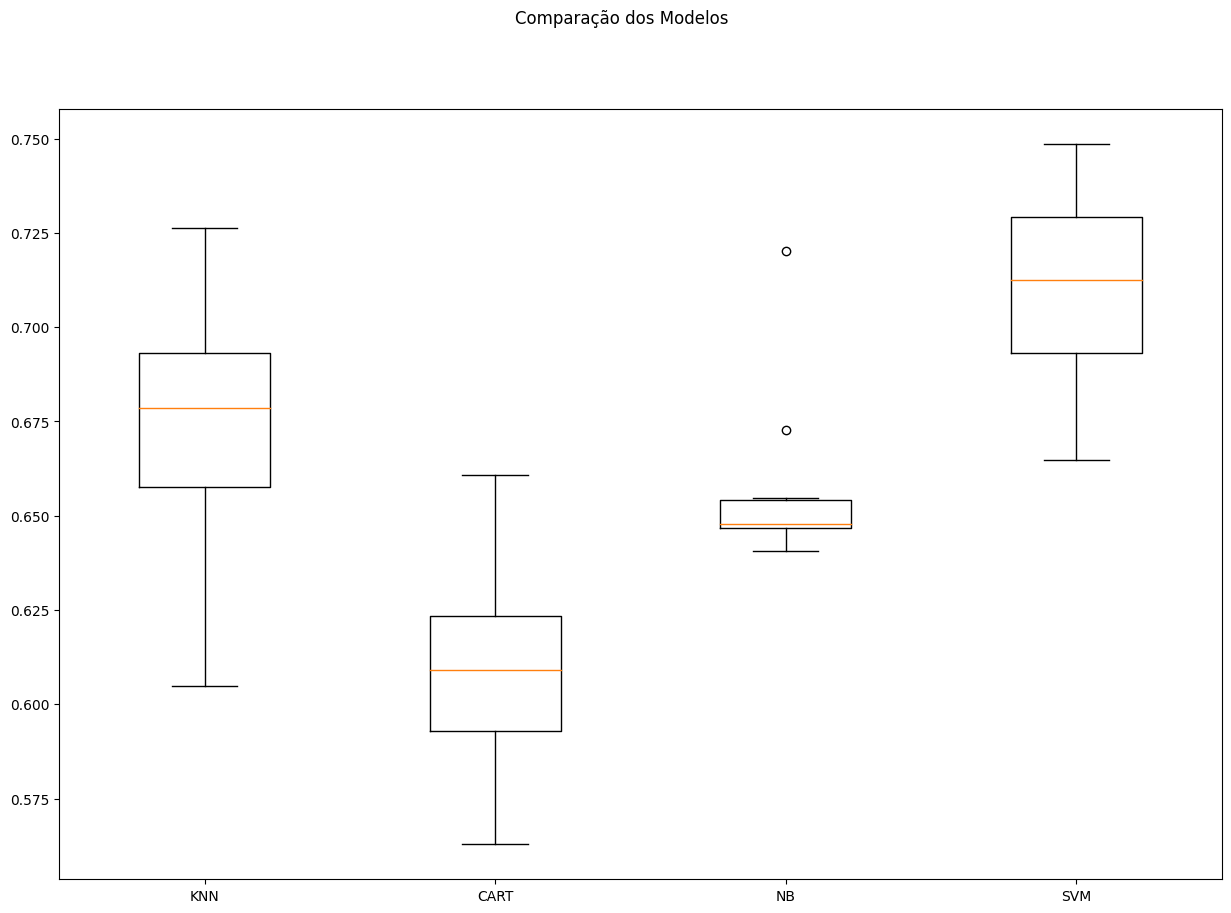

In [35]:
np.random.seed(seed) # definindo uma semente global

# Criando os modelos e adicionando-os na lista de modelos
training_models = {
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC()
}

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, training_model in training_models.items():
    cv_results = cross_val_score(training_model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.673 (0.032)
CART-orig: 0.609 (0.028)
NB-orig: 0.658 (0.022)
SVM-orig: 0.710 (0.027)
KNN-padr: 0.563 (0.026)
CART-padr: 0.616 (0.036)
NB-padr: 0.658 (0.022)
SVM-padr: 0.694 (0.016)
KNN-norm: 0.534 (0.028)
CART-norm: 0.613 (0.027)
NB-norm: 0.658 (0.022)
SVM-norm: 0.663 (0.013)


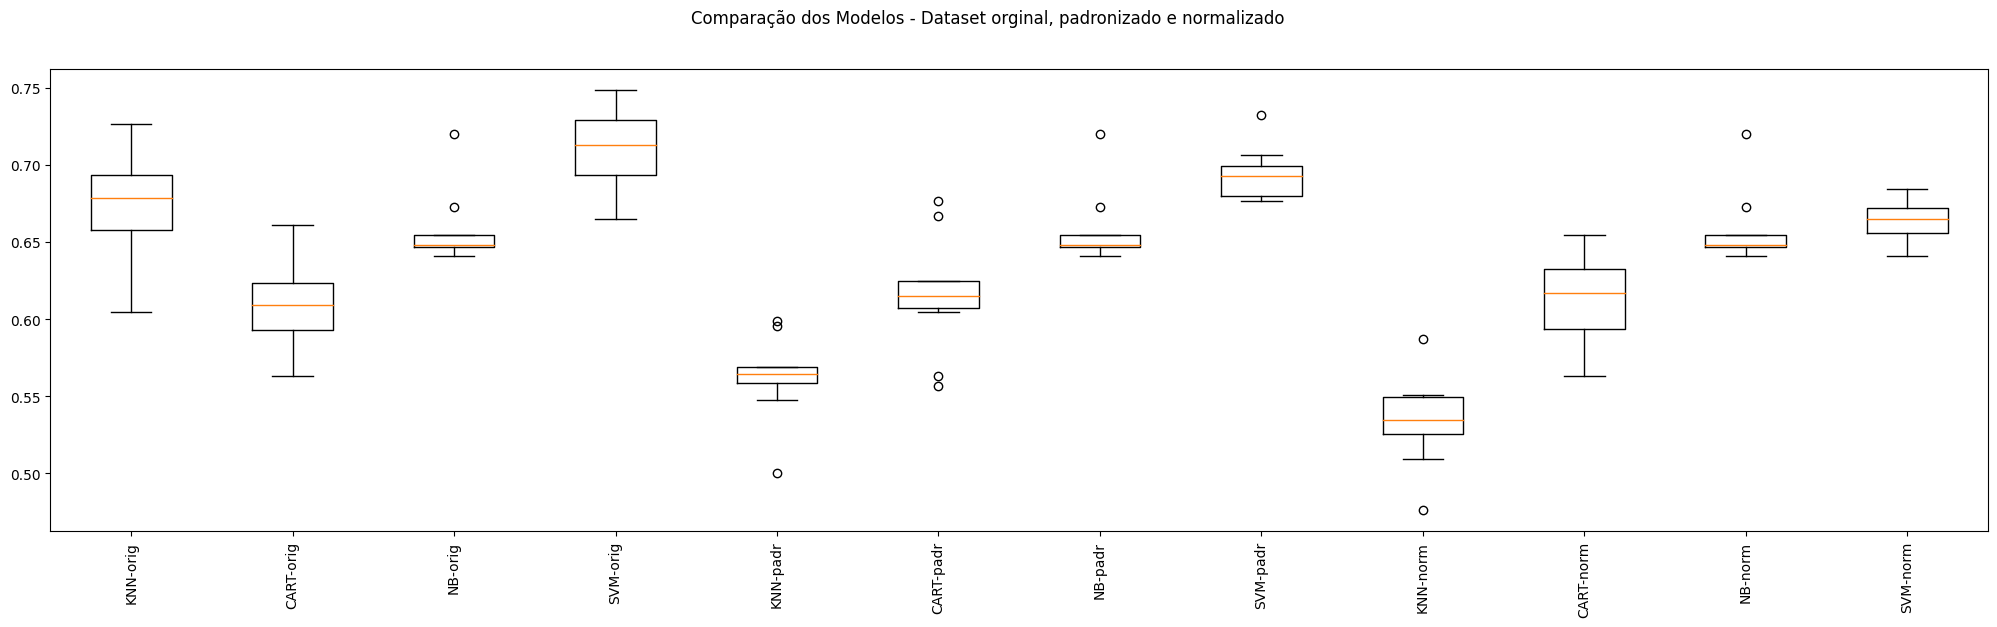

In [36]:
np.random.seed(seed) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, training_model in pipelines:
    cv_results = cross_val_score(training_model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

# Otimização dos hiperparâmetros

In [37]:
# Tuning do SVM

np.random.seed(seed) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__C': [0.1, 1, 10],
    'SVM__kernel': ['linear', 'polynomial', 'rbf'],
}

# Prepara e executa o GridSearchCV
for name, training_model in pipelines:
    grid = GridSearchCV(
        estimator=training_model, param_grid=param_grid,
        scoring=scoring, cv=kfold
    )
    grid.fit(x_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: svm-orig - Melhor: 0.749679 usando {'SVM__C': 0.1, 'SVM__kernel': 'linear'}
Sem tratamento de missings: svm-padr - Melhor: 0.744899 usando {'SVM__C': 10, 'SVM__kernel': 'linear'}
Sem tratamento de missings: svm-norm - Melhor: 0.745498 usando {'SVM__C': 10, 'SVM__kernel': 'linear'}


# Finalização do Modelo

In [38]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
# Melhores hiperparâmetros
best_kernel = 'linear'
best_C = 0.1
training_model = SVC(kernel=best_kernel, C=best_C)
training_model.fit(x_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = training_model.predict(x_test)
print(accuracy_score(y_test, predictions))

0.7506963788300836


In [39]:
# Preparação do modelo com TODO o dataset
training_model.fit(x, y)

SVC(C=0.1, kernel='linear')

Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [40]:
np.random.seed(seed)

pipeline = Pipeline(steps=[('SVM', training_model)])

pipeline.fit(x_train, y_train)
predictions = pipeline.predict(x_test)
print(accuracy_score(y_test, predictions))

0.7506963788300836


# Salvando os arquivos

In [45]:
# Salvando o modelo
root_folder = '/content/drive/MyDrive/Colab Notebooks/mvp-predicao-media-alunos'
model_filename = 'svm_student_performance_classifier.pkl'
with open(f'{root_folder}/models/{model_filename}', 'wb') as file:
    pickle.dump(training_model, file)

# Salvando o pipeline
pipeline_filename = 'svm_student_performance_pipeline.pkl'
with open(f'{root_folder}/pipelines/{pipeline_filename}', 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
# , columns=dataset.columns[:-1]
# , columns=[dataset.columns[-1]]
x_test_columns = dataset.columns.values[0:12]
y_test_columns = [dataset.columns.values[-1]]
x_test_df = pd.DataFrame(x_test, columns=x_test_columns)
y_test_df = pd.DataFrame(y_test, columns=y_test_columns)
x_test_df.to_csv(
    f'{root_folder}/data/x_test_dataset_student_performance.csv',
    index=False
)
y_test_df.to_csv(
    f'{root_folder}/data/y_test_dataset_student_performance.csv',
    index=False
)

# Simulando a aplicação do modelo em dados não vistos

In [50]:
# Novos dados - não sabemos a classe!
data = {
    'Age': [16, 16, 18],
    'Gender': [0, 1, 0],
    'Ethnicity': [2, 1, 3],
    'ParentalEducation': [1, 2, 3],
    'StudyTimeWeekly': [3.5282382085577235, 15.167695431798355, 9.864949860519715],
    'Absences': [16, 9, 20],
    'Tutoring': [1, 0, 0],
    'ParentalSupport': [2, 2, 2],
    'Extracurricular': [1, 0, 0],
    'Sports': [0, 0, 1],
    'Music': [1, 0, 0],
    'Volunteering': [0, 0, 0]
}

# Remover 'GradeClass'do dicionário de dados uma vez que não é um dado usada para predição
atributos = [
    'Age', 'Gender',
    'Ethnicity', 'ParentalEducation',
    'StudyTimeWeekly', 'Absences',
    'Tutoring', 'ParentalSupport',
    'Extracurricular', 'Sports',
    'Music', 'Volunteering'
]
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.to_numpy()
x_entrada = array_entrada[:,0:12]

In [53]:
# Predição de classes dos dados de entrada
notas = {
    0.0: 'A',
    1.0: 'B',
    2.0: 'C',
    3.0: 'D',
    4.0: 'E'
}
saidas = training_model.predict(x_entrada)
print([notas[saida] for saida in saidas])

['E', 'D', 'E']
